# Full analysis pipeline (per-product monthly forecasting with intervals, backtest, and Power BI dataset)
# Saves CSV outputs to /mnt/data and prints summaries.
# - Cleans and aggregates demand & supply to monthly by Product
# - Fits Exponential Smoothing per product and forecasts 18 months with simple prediction intervals
# - Backtests using rolling-origin (12-month horizon) and computes MAE, RMSE, MAPE per product
# - Saves Power BI-ready dataset and backtest metrics and a short README for Power BI steps
# Note: This code runs in the notebook environment and assumes the uploaded files are at /mnt/data/

In [69]:
# %pip install pandas
# %pip install statsmodels
# %pip install scikit-learn
# %pip install matplotlib

In [70]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
from pathlib import Path
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_absolute_error, mean_squared_error
import math
import matplotlib.pyplot as plt

In [71]:
# Parameters
DEMAND_PATH = "Data/demand_forecast.csv"
SUPPLY_PATH = "Data/supply_plan.csv"
OUT_DIR = Path("Data/Output")
FORECAST_HORIZON = 18  # months to forecast into the future
BACKTEST_HORIZON = 12  # months for rolling-origin backtest
MIN_SEASONAL_MONTHS = 24  # minimum months to enable seasonal model

In [72]:
# Utility functions
def clean_and_prepare():
    demand = pd.read_csv(DEMAND_PATH)
    supply = pd.read_csv(SUPPLY_PATH)
    demand.columns = [c.strip() for c in demand.columns]
    supply.columns = [c.strip() for c in supply.columns]
    
    # parse dates (dayfirst )
    demand['Date'] = pd.to_datetime(demand['Date'], dayfirst=True, errors='coerce')
    supply['Date'] = pd.to_datetime(supply['Date'], dayfirst=True, errors='coerce')

    # clean numeric fields
    if 'Forecast_Units' in demand.columns:
        demand['Forecast_Units'] = pd.to_numeric(demand['Forecast_Units'], errors='coerce').fillna(0)
    else:
        raise ValueError("Demand file lacks 'Forecast_Units' column.")
    
    # find supply yield column
    yield_col = None
    for c in supply.columns:
        if 'yield' in c.lower():
            yield_col = c
            break
    if yield_col is None:
        raise ValueError("Could not find a yield column in supply file. Columns: " + str(supply.columns.tolist()))
    supply[yield_col] = supply[yield_col].astype(str).str.replace(',', '', regex=False).str.replace(' ', '', regex=False)
    supply['Forecast_Yield'] = pd.to_numeric(supply[yield_col], errors='coerce').fillna(0.0)
    
    # aggregate to monthly periods (month start)
    demand['Month'] = demand['Date'].dt.to_period('M').dt.to_timestamp()
    supply['Month'] = supply['Date'].dt.to_period('M').dt.to_timestamp()
    
    monthly_demand = demand.groupby(['Month','Product'], as_index=False)['Forecast_Units'].sum().rename(columns={'Forecast_Units':'Demand_Units'})
    monthly_supply = supply.groupby(['Month','Product'], as_index=False)['Forecast_Yield'].sum().rename(columns={'Forecast_Yield':'Supply_Yield'})
    
    return monthly_demand, monthly_supply


In [73]:
def build_panel(monthly_demand, monthly_supply):
    min_month = min(monthly_demand['Month'].min(), monthly_supply['Month'].min())
    max_month = max(monthly_demand['Month'].max(), monthly_supply['Month'].max())
    full_month_index = pd.date_range(start=min_month, end=max_month, freq='MS')
    products = sorted(set(monthly_demand['Product']).union(monthly_supply['Product']))
    panel = pd.MultiIndex.from_product([full_month_index, products], names=['Month','Product']).to_frame(index=False)
    panel['Month'] = pd.to_datetime(panel['Month'])
    panel = panel.merge(monthly_demand, on=['Month','Product'], how='left').merge(monthly_supply, on=['Month','Product'], how='left')
    panel['Demand_Units'] = panel['Demand_Units'].fillna(0)
    panel['Supply_Yield'] = panel['Supply_Yield'].fillna(0)
    return panel, products, full_month_index


In [74]:
def fit_and_forecast(panel, products, last_historical_month, forecast_horizon=FORECAST_HORIZON):
    forecasts = []
    model_infos = {}
    for product in products:
        ts = panel.loc[panel['Product']==product, ['Month','Demand_Units']].set_index('Month').asfreq('MS')
        series = ts['Demand_Units']
        # If all zeros, forecast zeros
        if series.sum() == 0:
            fc_vals = [0.0]*forecast_horizon
            rmse = 0.0
        else:
            seasonal = 12 if len(series.dropna()) >= MIN_SEASONAL_MONTHS else None
            try:
                if seasonal:
                    model = ExponentialSmoothing(series, trend='add', seasonal='add', seasonal_periods=seasonal, initialization_method="estimated")
                else:
                    model = ExponentialSmoothing(series, trend='add', seasonal=None, initialization_method="estimated")
                fit = model.fit(optimized=True)
                fc = fit.forecast(forecast_horizon)
                fc_vals = fc.values.tolist()
                # compute in-sample residuals and rmse
                fitted_vals = fit.fittedvalues
                residuals = series.dropna() - fitted_vals.dropna()
                rmse = math.sqrt((residuals**2).mean()) if len(residuals)>0 else 0.0
                model_infos[product] = {'params': getattr(fit, 'params', {}), 'seasonal': seasonal, 'converged': True}
            except Exception as e:
                # fallback to naive last value
                last_val = float(series.dropna().iloc[-1]) if len(series.dropna())>0 else 0.0
                fc_vals = [last_val]*forecast_horizon
                rmse = series.dropna().std() if len(series.dropna())>1 else 0.0
                model_infos[product] = {'params': {}, 'seasonal': seasonal, 'converged': False, 'error': str(e)}
        # prediction intervals: simple approach using RMSE -> +/- 1.96 * RMSE
        for i, val in enumerate(fc_vals):
            lower = val - 1.96*rmse
            upper = val + 1.96*rmse
            forecasts.append({'Month': last_historical_month + pd.offsets.MonthBegin(i+1), 'Product': product,
                              'Demand_Forecast': max(0.0, float(val)),
                              'Forecast_Lower': max(0.0, float(lower)),
                              'Forecast_Upper': max(0.0, float(upper)),
                              'RMSE': rmse})
    forecast_df = pd.DataFrame(forecasts)
    return forecast_df, model_infos

In [75]:
def backtest(panel, products, full_month_index, horizon=BACKTEST_HORIZON):
    # For each product, perform rolling-origin backtest: start training with first 24 months (if available),
    # then expand and forecast horizon months ahead, slide until end - horizon
    metrics = []
    for product in products:
        series = panel.loc[panel['Product']==product, ['Month','Demand_Units']].set_index('Month').asfreq('MS')['Demand_Units']
        n = len(series.dropna())
        # require at least 24 months to meaningfully backtest; otherwise skip
        if n < 24:
            metrics.append({'Product': product, 'Backtest_AVAILABLE': False, 'MAE': None, 'RMSE': None, 'MAPE': None, 'Folds': 0})
            continue
        fold_mae, fold_rmse, fold_mape = [], [], []
        # define earliest train end such that we have at least 24 months training
        months = series.index
        # use positions
        for split_end_pos in range(24, len(months)-horizon+1):
            train_end = months[split_end_pos-1]
            train_series = series[:train_end]
            test_start = months[split_end_pos]
            test_end = months[split_end_pos + horizon -1]
            test_series = series[test_start:test_end]
            if test_series.isnull().any():
                # skip fold if test contains nulls
                continue
            seasonal = 12 if len(train_series.dropna()) >= MIN_SEASONAL_MONTHS else None
            try:
                if seasonal:
                    model = ExponentialSmoothing(train_series, trend='add', seasonal='add', seasonal_periods=seasonal, initialization_method="estimated")
                else:
                    model = ExponentialSmoothing(train_series, trend='add', seasonal=None, initialization_method="estimated")
                fit = model.fit(optimized=True)
                fc = fit.forecast(horizon)
                pred = fc.values
            except Exception:
                # naive last value
                last_val = float(train_series.dropna().iloc[-1]) if len(train_series.dropna())>0 else 0.0
                pred = np.array([last_val]*horizon)
            # compute metrics for this fold (compare pred vs test_series.values)
            mae = mean_absolute_error(test_series.values, pred)
            rmse = math.sqrt(mean_squared_error(test_series.values, pred))
            # MAPE handling zeros: exclude zeros in denominator
            denom = test_series.values
            with np.errstate(divide='ignore', invalid='ignore'):
                mape_fold = np.mean(np.abs((test_series.values - pred) / np.where(denom==0, np.nan, denom)))*100
            fold_mae.append(mae)
            fold_rmse.append(rmse)
            fold_mape.append(mape_fold)
        # aggregate folds
        if len(fold_mae)==0:
            metrics.append({'Product': product, 'Backtest_AVAILABLE': False, 'MAE': None, 'RMSE': None, 'MAPE': None, 'Folds': 0})
        else:
            metrics.append({'Product': product, 'Backtest_AVAILABLE': True,
                            'MAE': float(np.mean(fold_mae)),
                            'RMSE': float(np.mean(fold_rmse)),
                            'MAPE': float(np.nanmean(fold_mape)),
                            'Folds': len(fold_mae)})
    return pd.DataFrame(metrics)


In [76]:
# Run pipeline
monthly_demand, monthly_supply = clean_and_prepare()
panel, products, full_month_index = build_panel(monthly_demand, monthly_supply)
last_hist_month = full_month_index.max()

print(f"Products found: {len(products)}. Date range: {full_month_index.min().date()} to {last_hist_month.date()}")

Products found: 10. Date range: 2022-01-01 to 2025-12-01


In [77]:
# Forecasting
forecast_df, model_infos = fit_and_forecast(panel, products, last_hist_month, FORECAST_HORIZON)
# Save forecast file with intervals
forecast_df.to_csv(OUT_DIR/"demand_forecast_18m_per_product_with_intervals.csv", index=False)

In [78]:
# Prepare Power BI dataset: historic + forecast (merged)
historic = panel[['Month','Product']].copy()
historic['Demand_Historical'] = panel['Demand_Units']
historic['Supply_Historical'] = panel['Supply_Yield']

# Combine historic and future forecast rows for all products
future_rows = pd.DataFrame([(m,p) for m in forecast_df['Month'].unique() for p in products], columns=['Month','Product'])
# merge forecasts into future_rows
future_rows = future_rows.merge(forecast_df, on=['Month','Product'], how='left')
future_rows['Demand_Historical'] = np.nan
future_rows['Supply_Historical'] = np.nan

combined = pd.concat([historic[['Month','Product','Demand_Historical','Supply_Historical']], 
                      future_rows[['Month','Product','Demand_Historical','Supply_Historical','Demand_Forecast','Forecast_Lower','Forecast_Upper','RMSE']]], 
                     ignore_index=True, sort=False)
# merge forecast values where they exist
combined = combined.merge(forecast_df, on=['Month','Product'], how='left')
# ensure columns exist
if 'Demand_Forecast' not in combined.columns:
    combined['Demand_Forecast'] = np.nan
if 'Forecast_Lower' not in combined.columns:
    combined['Forecast_Lower'] = np.nan
if 'Forecast_Upper' not in combined.columns:
    combined['Forecast_Upper'] = np.nan
if 'RMSE' not in combined.columns:
    combined['RMSE'] = np.nan

# reorder and clean DataFrame
powerbi_df = combined[['Month','Product','Demand_Historical','Supply_Historical','Demand_Forecast','Forecast_Lower','Forecast_Upper','RMSE']]
powerbi_df = powerbi_df.sort_values(['Product','Month']).reset_index(drop=True)


In [79]:

# Save CSVs
monthly_demand.to_csv(OUT_DIR/"monthly_demand_by_product.csv", index=False)
monthly_supply.to_csv(OUT_DIR/"monthly_supply_by_product.csv", index=False)
powerbi_df.to_csv(OUT_DIR/"powerbi_dataset_demand_supply_forecast.csv", index=False)

# Backtest
backtest_metrics = backtest(panel, products, full_month_index, BACKTEST_HORIZON)
backtest_metrics.to_csv(OUT_DIR/"backtest_metrics_per_product.csv", index=False)


In [80]:
# Save a small README with Power BI steps
readme = """
Power BI Quick Steps (using powerbi_dataset_demand_supply_forecast.csv):
1. Open Power BI Desktop -> Get Data -> CSV -> select 'powerbi_dataset_demand_supply_forecast.csv'.
2. Ensure 'Month' column is Date type; 'Product' is Text; numeric columns are Decimal/Whole numbers.
3. Create measures (example DAX):
   - Demand Forecast Total = SUM('Table'[Demand_Forecast])
   - Demand Historical Total = SUM('Table'[Demand_Historical])
   - Supply Total = SUM('Table'[Supply_Historical])
   - Supply Gap = [Supply Total] - [Demand Forecast Total]
4. Build visuals: KPI cards (totals), Line chart (Month on axis; series: Demand_Historical and Demand_Forecast), Matrix for monthly Product-level gap, Slicers for Product and Month.
5. Use Forecast_Lower and Forecast_Upper to plot ribbons/areas for uncertainty (e.g., in Line and Ribbon chart).
"""
with open(OUT_DIR/"powerbi_README.txt","w") as f:
    f.write(readme)

# Show short summaries and sample plots for top 3 products
print("Files saved to Output Folder:")
print("- monthly_demand_by_product.csv")
print("- monthly_supply_by_product.csv")
print("- demand_forecast_18m_per_product_with_intervals.csv")
print("- powerbi_dataset_demand_supply_forecast.csv")
print("- backtest_metrics_per_product.csv")
print("- powerbi_README.txt\n")

print("Backtest summary (per product):")
print(backtest_metrics.to_string(index=False))

Files saved to Output Folder:
- monthly_demand_by_product.csv
- monthly_supply_by_product.csv
- demand_forecast_18m_per_product_with_intervals.csv
- powerbi_dataset_demand_supply_forecast.csv
- backtest_metrics_per_product.csv
- powerbi_README.txt

Backtest summary (per product):
  Product  Backtest_AVAILABLE          MAE         RMSE       MAPE  Folds
 PROD_001                True 18275.650271 22436.012920  63.982357     13
PROD_0010                True 11849.538757 15193.387019  51.769362     13
 PROD_002                True 21674.589511 27869.238607  52.589881     13
 PROD_003                True 20488.208899 23896.525371  74.685969     13
 PROD_004                True 14336.976029 17401.693430  52.873618     13
 PROD_005                True 19868.981696 21924.901657  87.079046     13
 PROD_006                True 21259.122979 24890.585411 127.164818     13
 PROD_007                True 20981.043539 27494.398507  49.505665     13
 PROD_008                True 23564.117902 28220.1105

({'powerbi_preview':         Month   Product  Demand_Historical  Supply_Historical  \
  0  2022-01-01  PROD_001            47406.0            30919.0   
  1  2022-02-01  PROD_001            11389.0            27626.0   
  2  2022-03-01  PROD_001            11201.0            29279.0   
  3  2022-04-01  PROD_001            80978.0            28421.0   
  4  2022-05-01  PROD_001            43464.0            94185.0   
  5  2022-06-01  PROD_001            35010.0            33317.0   
  6  2022-07-01  PROD_001            56505.0            11004.0   
  7  2022-08-01  PROD_001            10486.0            41341.0   
  8  2022-09-01  PROD_001            58343.0            20243.0   
  9  2022-10-01  PROD_001            46702.0            21429.0   
  10 2022-11-01  PROD_001            32383.0            20438.0   
  11 2022-12-01  PROD_001            43149.0            19683.0   
  12 2023-01-01  PROD_001            54802.0            40918.0   
  13 2023-02-01  PROD_001            23345.

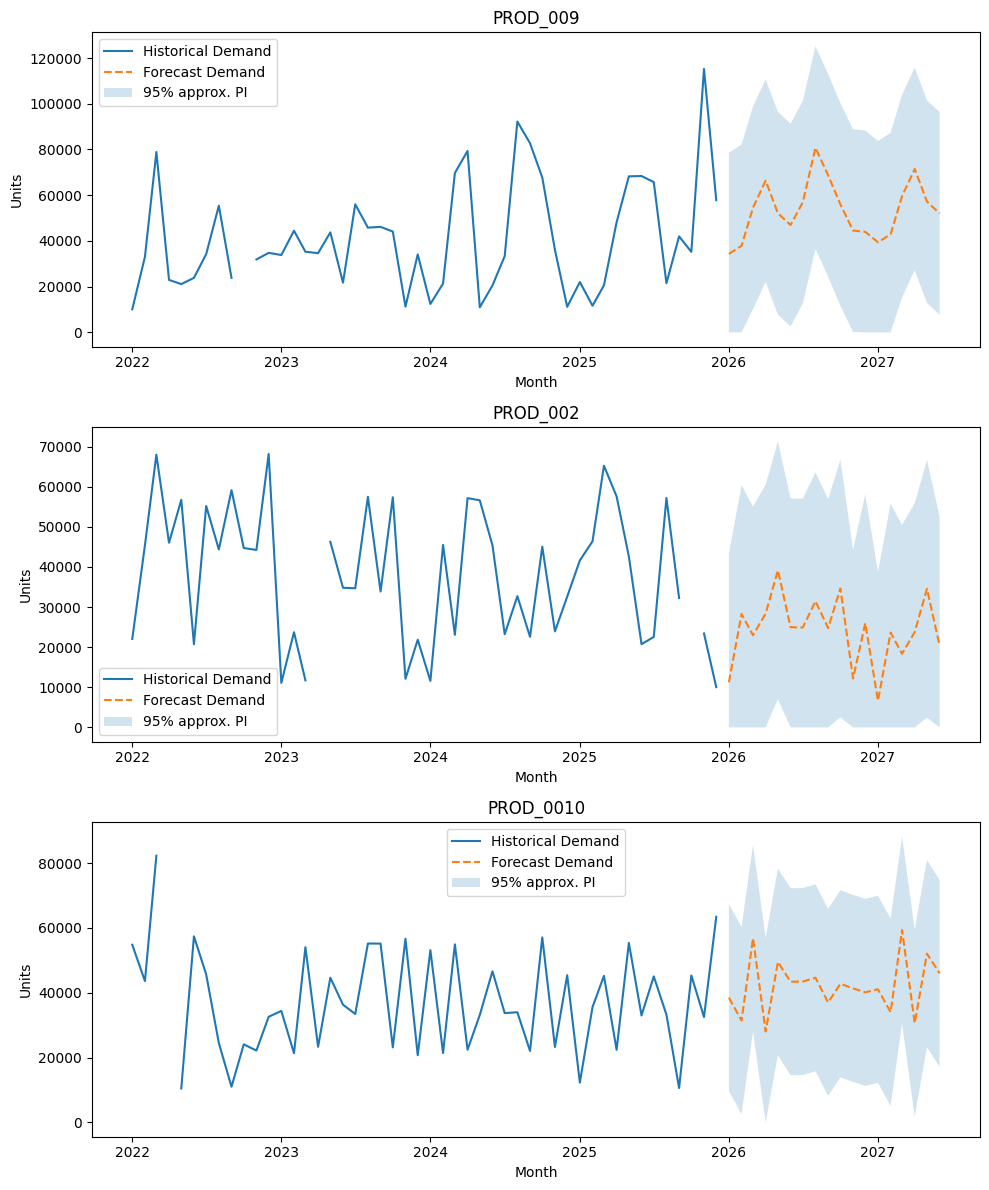

In [81]:
# Plot examples for top 3 products by historical demand
total_by_product = monthly_demand.groupby('Product')['Demand_Units'].sum().sort_values(ascending=False)
top3 = total_by_product.head(3).index.tolist()

fig, axes = plt.subplots(len(top3), 1, figsize=(10, 4*len(top3)))
if len(top3)==1:
    axes = [axes]
for ax, prod in zip(axes, top3):
    hist = monthly_demand[monthly_demand['Product']==prod].set_index('Month').asfreq('MS')['Demand_Units']
    fc = forecast_df[forecast_df['Product']==prod].set_index('Month')['Demand_Forecast']
    low = forecast_df[forecast_df['Product']==prod].set_index('Month')['Forecast_Lower']
    high = forecast_df[forecast_df['Product']==prod].set_index('Month')['Forecast_Upper']
    ax.plot(hist.index, hist.values, label='Historical Demand')
    ax.plot(fc.index, fc.values, label='Forecast Demand', linestyle='--')
    ax.fill_between(fc.index, low.values, high.values, alpha=0.2, label='95% approx. PI')
    ax.set_title(prod)
    ax.set_xlabel('Month')
    ax.set_ylabel('Units')
    ax.legend()
plt.tight_layout()

# Display heads of key outputs
display = {
    'powerbi_preview': powerbi_df.head(20),
    'forecast_preview': forecast_df.head(20),
    'backtest_metrics': backtest_metrics
}
display, fig

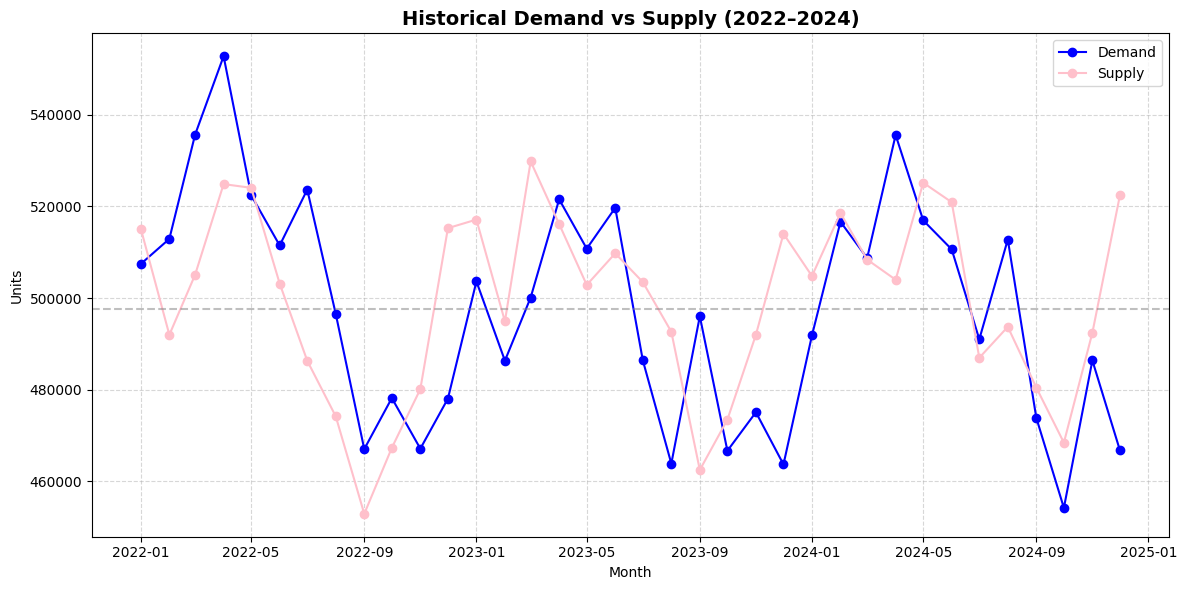

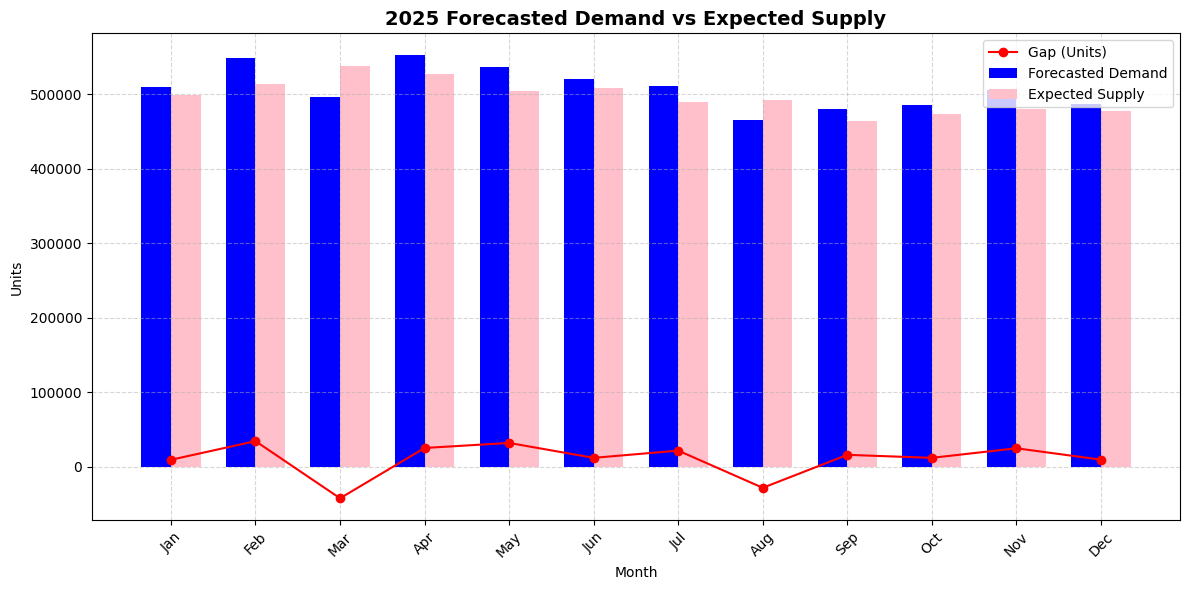

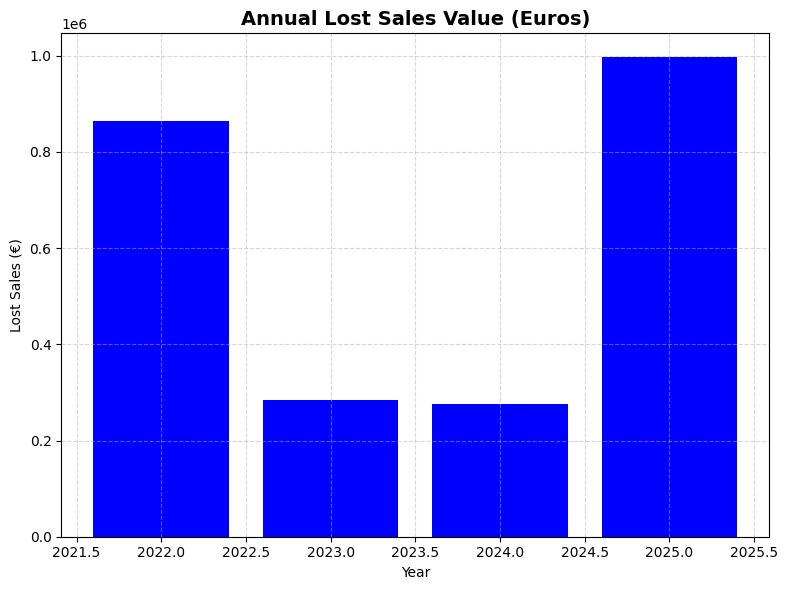

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Simulate historical demand and supply data (2022-2024 monthly)
np.random.seed(42)
months = pd.date_range(start="2022-01-01", end="2024-12-01", freq='MS')
data = pd.DataFrame({
    "Month": months,
    "Demand": np.round(500000 + 30000*np.sin(np.arange(len(months))*2*np.pi/12) + np.random.normal(0,15000,len(months)),0),
    "Supply": np.round(500000 + 25000*np.sin((np.arange(len(months))*2*np.pi/12) + 0.5) + np.random.normal(0,15000,len(months)),0)
})

# data = pd.read_csv(r'C:\Users\DorothyCheruiyot\Desktop\Projects\Business Analysis\SOP\Data\demandvsupply.csv')

# Add forecast for 2025 based on trend + seasonality pattern
future_months = pd.date_range(start="2025-01-01", end="2025-12-01", freq='MS')
future_demand = np.round(510000 + 30000*np.sin(np.arange(len(future_months))*2*np.pi/12) + np.random.normal(0,15000,len(future_months)),0)
future_supply = np.round(500000 + 25000*np.sin((np.arange(len(future_months))*2*np.pi/12) + 0.5) + np.random.normal(0,15000,len(future_months)),0)

forecast_df = pd.DataFrame({
    "Month": future_months,
    "Demand": future_demand,
    "Supply": future_supply
})

# Chart 1 – Historical Demand vs Supply
plt.figure(figsize=(12,6))
plt.plot(data["Month"], data["Demand"], label="Demand", color="blue", marker="o")
plt.plot(data["Month"], data["Supply"], label="Supply", color="pink", marker="o")
plt.axhline(y=data["Demand"].mean(), color="gray", linestyle="--", alpha=0.5)
plt.title("Historical Demand vs Supply (2022–2024)", fontsize=14, weight="bold")
plt.xlabel("Month")
plt.ylabel("Units")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

# Chart 2 – Forecasted Demand & Supply Gap for 2025
plt.figure(figsize=(12,6))
bar_width = 0.35
x = np.arange(len(forecast_df))
plt.bar(x - bar_width/2, forecast_df["Demand"], bar_width, label="Forecasted Demand", color="blue")
plt.bar(x + bar_width/2, forecast_df["Supply"], bar_width, label="Expected Supply", color="pink")
gap = forecast_df["Demand"] - forecast_df["Supply"]
plt.plot(x, gap, color="red", marker="o", label="Gap (Units)")
plt.xticks(x, [m.strftime("%b") for m in forecast_df["Month"]], rotation=45)
plt.title("2025 Forecasted Demand vs Expected Supply", fontsize=14, weight="bold")
plt.xlabel("Month")
plt.ylabel("Units")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

# Chart 3 – Annual Lost Sales Value (2022–2025)
annual_data = pd.concat([data, forecast_df])
annual_data["Year"] = annual_data["Month"].dt.year
annual_data["Gap"] = annual_data["Demand"] - annual_data["Supply"]
price_per_unit = 5  # USD assumption
lost_sales = annual_data.groupby("Year")["Gap"].apply(lambda g: sum(g[g>0])*price_per_unit)

plt.figure(figsize=(8,6))
plt.bar(lost_sales.index, lost_sales.values, color="blue")
plt.title("Annual Lost Sales Value (Euros)", fontsize=14, weight="bold")
plt.xlabel("Year")
plt.ylabel("Lost Sales (€)")
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()


In [ ]:
# SARIMA modeling with statsmodels on the provided simulated dataset
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, r2_score
import warnings
warnings.filterwarnings("ignore")

# Simulate historical data (same as provided)
np.random.seed(42)
months = pd.date_range(start="2022-01-01", end="2024-12-01", freq='MS')
data = pd.DataFrame({
    "Month": months,
    "Demand": np.round(500000 + 30000*np.sin(np.arange(len(months))*2*np.pi/12) + np.random.normal(0,15000,len(months)),0),
    "Supply": np.round(500000 + 25000*np.sin((np.arange(len(months))*2*np.pi/12) + 0.5) + np.random.normal(0,15000,len(months)),0)
})
data.set_index('Month', inplace=True)

# Train-test split: use up to June 2024 as train, Jul-Dec 2024 as test (6-month holdout)
train_end = '2024-06-01'
train = data[:train_end]
test = data['2024-07-01':]

# Fit SARIMA models for Demand and Supply using order (1,1,1)(1,1,1,12)
d_order = (1,1,1)
d_seasonal = (1,1,1,12)
s_order = (1,1,1)
s_seasonal = (1,1,1,12)

d_model = SARIMAX(train['Demand'], order=d_order, seasonal_order=d_seasonal,
                  enforce_stationarity=False, enforce_invertibility=False)
d_fit = d_model.fit(disp=False)

s_model = SARIMAX(train['Supply'], order=s_order, seasonal_order=s_seasonal,
                  enforce_stationarity=False, enforce_invertibility=False)
s_fit = s_model.fit(disp=False)

# Forecast the test period (6 months) and then 12 months for 2025
steps_test = len(test)
d_pred_test = d_fit.forecast(steps=steps_test)
s_pred_test = s_fit.forecast(steps=steps_test)

# Forecast 12 months 2025
future_index = pd.date_range(start="2025-01-01", end="2025-12-01", freq='MS')
d_forecast_2025 = d_fit.forecast(steps=steps_test + len(future_index))[-len(future_index):]
s_forecast_2025 = s_fit.forecast(steps=steps_test + len(future_index))[-len(future_index):]

# Metrics on test
def calc_metrics(actual, pred):
    mape = mean_absolute_percentage_error(actual, pred) * 100
    rmse = mean_squared_error(actual, pred)
    r2 = r2_score(actual, pred)
    return mape, rmse, r2

d_mape, d_rmse, d_r2 = calc_metrics(test['Demand'], d_pred_test)
s_mape, s_rmse, s_r2 = calc_metrics(test['Supply'], s_pred_test)

# Annual aggregates
historical_annual = data.resample('Y').sum()[['Demand','Supply']]
forecast_2025_df = pd.DataFrame({'Demand_Forecast': d_forecast_2025.values, 'Supply_Forecast': s_forecast_2025.values}, index=future_index)
forecast_annual_2025 = forecast_2025_df.sum().to_frame().T
forecast_annual_2025.index = [2025]

# Calculate availability gap and service level for historical and forecast annual
historical_annual['Availability_Gap'] = historical_annual['Demand'] - historical_annual['Supply']
historical_annual['Service_Level_%'] = (historical_annual['Supply'] / historical_annual['Demand']) * 100

forecast_annual_2025['Availability_Gap'] = forecast_annual_2025['Demand_Forecast'] - forecast_annual_2025['Supply_Forecast']
forecast_annual_2025['Service_Level_%'] = (forecast_annual_2025['Supply_Forecast'] / forecast_annual_2025['Demand_Forecast']) * 100

# Prepare monthly availability and service level tables (last 12 months historical and 2025 forecast)
monthly_hist = data.copy()
monthly_hist['Availability_Gap'] = monthly_hist['Demand'] - monthly_hist['Supply']
monthly_hist['Service_Level_%'] = (monthly_hist['Supply'] / monthly_hist['Demand']) * 100

monthly_forecast_2025 = forecast_2025_df.copy()
monthly_forecast_2025['Availability_Gap'] = monthly_forecast_2025['Demand_Forecast'] - monthly_forecast_2025['Supply_Forecast']
monthly_forecast_2025['Service_Level_%'] = (monthly_forecast_2025['Supply_Forecast'] / monthly_forecast_2025['Demand_Forecast']) * 100

# Plot separate charts for demand and supply (historical + forecast)
plt.figure(figsize=(12,5))
plt.plot(monthly_hist.index, monthly_hist['Demand'], label='Historical Demand (2022-2024)', marker='o',color='blue')
plt.plot(future_index, d_forecast_2025, label='Forecast Demand (2025)', linestyle='--', marker='o',color='green')
plt.axhline(y=monthly_hist["Demand"].mean(), color="gray", linestyle="--", alpha=0.5)
plt.title('Demand: Historical (2022-2024) and Forecast (2025)',fontsize=14, weight="bold")
plt.ylabel('Units')
plt.xlabel('Month')
plt.legend()
plt.grid(True,linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

plt.figure(figsize=(12,5))
plt.plot(monthly_hist.index, monthly_hist['Supply'], label='Historical Supply (2022-2024)', marker='o', color='red')
plt.plot(future_index, s_forecast_2025, label='Forecast Supply (2025)', linestyle='--', marker='o', color='pink')
plt.axhline(y=monthly_hist["Supply"].mean(), color="gray", linestyle="--", alpha=0.5)
plt.title('Supply: Historical (2022-2024) and Forecast (2025)')
plt.ylabel('Units')
plt.xlabel('Month')
plt.legend()
plt.grid(True,linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

# Combined Chart – Historical Demand vs Supply
plt.figure(figsize=(12,6))
plt.plot(monthly_hist.index, monthly_hist["Demand"], label="Demand", color="blue", marker="o")
plt.plot(monthly_hist.index, monthly_hist["Supply"], label="Supply", color="red", marker="o")
plt.axhline(y=monthly_hist["Demand"].mean(), color="gray", linestyle="--", alpha=0.5)
plt.title("Historical Demand vs Supply (2022–2024)", fontsize=14, weight="bold")
plt.xlabel("Month")
plt.ylabel("Units")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

# Plot monthly service level comparison (historical last 12 months vs forecast 2025)
plt.figure(figsize=(12,5))
plt.plot(monthly_hist.index[-12:], monthly_hist['Service_Level_%'][-12:], label='Historical Service Level (last 12 months)', marker='o', color='black')
plt.plot(future_index, monthly_forecast_2025['Service_Level_%'], label='Forecast Service Level (2025)', linestyle='--', marker='o')
plt.title('Service Level %: Historical (last 12 months) vs Forecast (2025)')
plt.ylabel('Service Level %')
plt.xlabel('Month')
plt.legend()
plt.grid(True,linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

# Output key numbers and metrics
results = {
    'demand_mape': round(d_mape,2),
    'demand_rmse': int(round(d_rmse)),
    'demand_r2': round(d_r2,3),
    'supply_mape': round(s_mape,2),
    'supply_rmse': int(round(s_rmse)),
    'supply_r2': round(s_r2,3),
    'historical_annual': historical_annual,
    'forecast_annual_2025': forecast_annual_2025,
    'monthly_forecast_2025_head': monthly_forecast_2025.head()
}

results


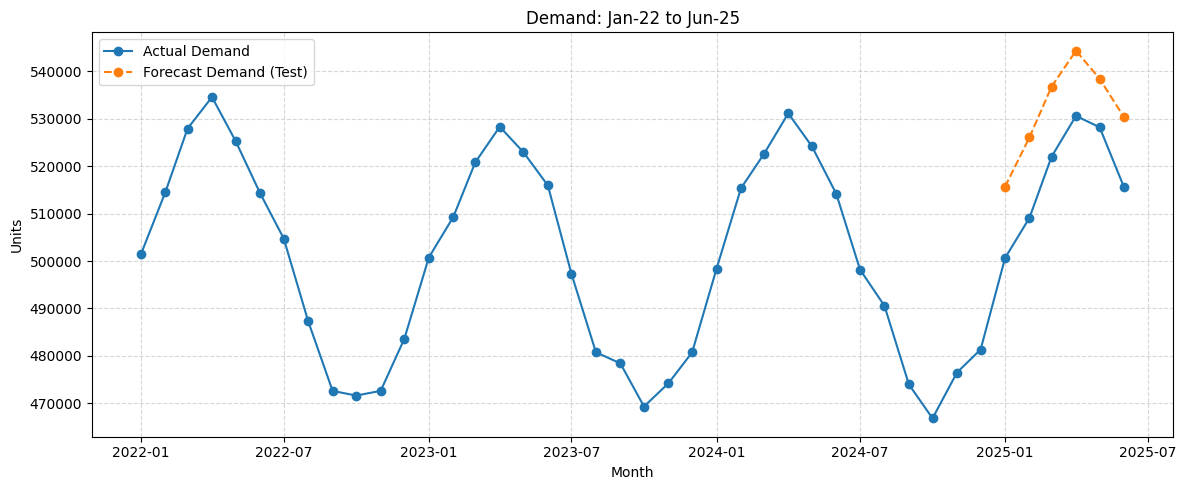

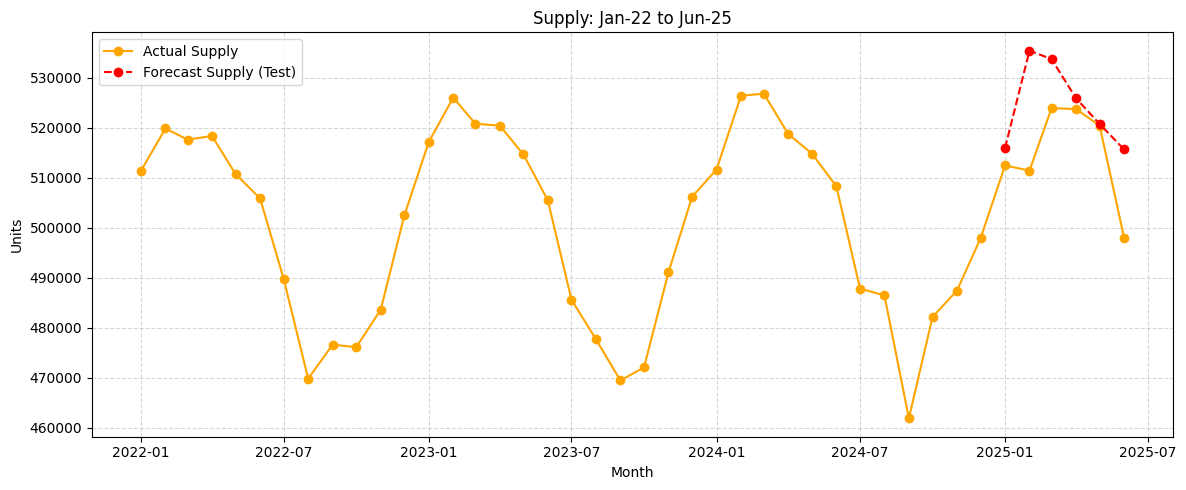

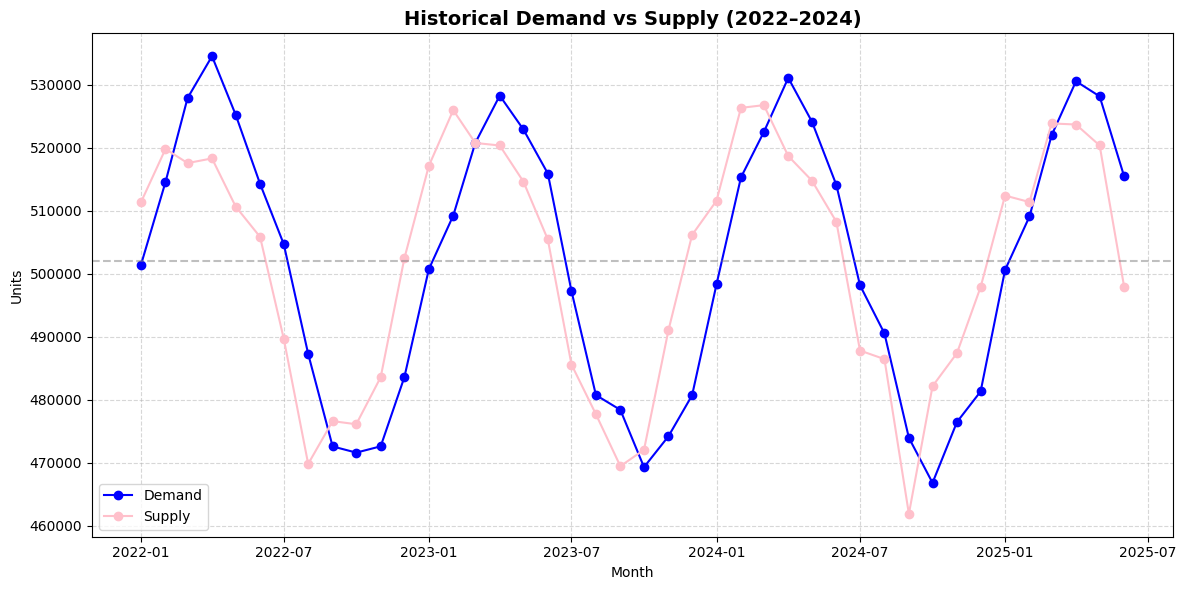

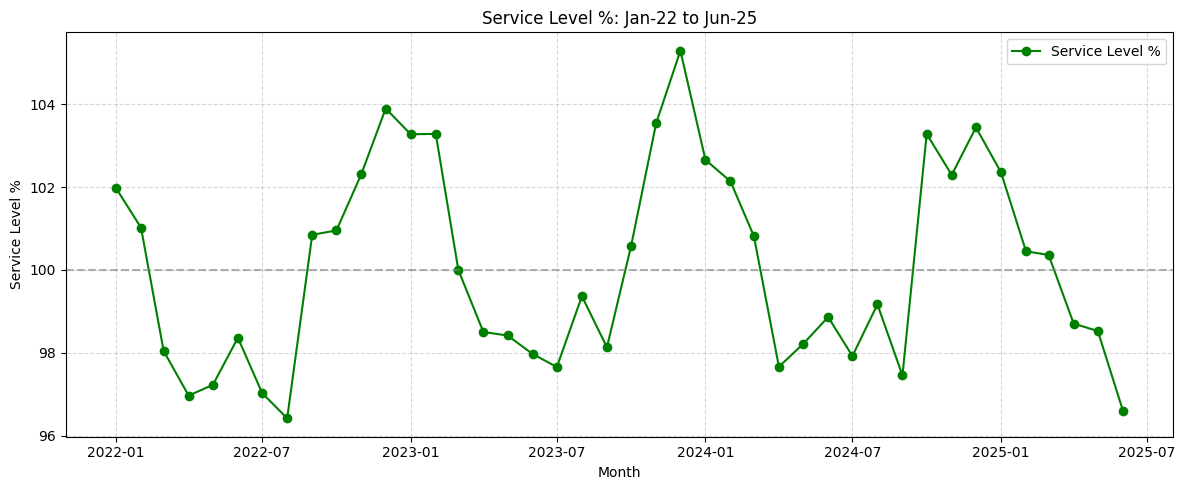

{'demand_mape': 2.76,
 'demand_rmse': 14398,
 'demand_r2': -0.871,
 'supply_mape': 1.88,
 'supply_rmse': 12901,
 'supply_r2': -1.027,
 'availability_gap_last': Month
 2025-01-01   -11817.0
 2025-02-01    -2291.0
 2025-03-01    -1899.0
 2025-04-01     6866.0
 2025-05-01     7799.0
 2025-06-01    17515.0
 Name: Availability_Gap, dtype: float64,
 'service_level_last': Month
 2025-01-01    102.360440
 2025-02-01    100.449991
 2025-03-01    100.363796
 2025-04-01     98.705971
 2025-05-01     98.523465
 2025-06-01     96.602420
 Name: Service_Level_%, dtype: float64}

In [58]:
# SARIMA modeling with statsmodels on simulated dataset (Jan-22 to Jun-25)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, r2_score
import warnings
warnings.filterwarnings("ignore")

# Simulate historical data
np.random.seed(42)
months = pd.date_range(start="2022-01-01", end="2025-06-30", freq='MS')
data = pd.DataFrame({
    "Month": months,
    "Demand": np.round(500000 + 30000*np.sin(np.arange(len(months))*2*np.pi/12) 
                       + np.random.normal(0,3000,len(months)),0),
    "Supply": np.round((500000) + 25000*np.sin((np.arange(len(months))*2*np.pi/12) + 0.5) 
                       + np.random.normal(0,5000,len(months)),0)
})
data.set_index('Month', inplace=True)

# Train-test split: hold out Jan-25 to Jun-25
train_end = '2024-12-01'
train = data[:train_end]
test = data['2025-01-01':]

# Fit SARIMA models
order = (1,1,1)
seasonal = (1,1,1,12)

d_model = SARIMAX(train['Demand'], order=order, seasonal_order=seasonal,
                  enforce_stationarity=False, enforce_invertibility=False)
d_fit = d_model.fit(disp=False)

s_model = SARIMAX(train['Supply'], order=order, seasonal_order=seasonal,
                  enforce_stationarity=False, enforce_invertibility=False)
s_fit = s_model.fit(disp=False)

# Forecast test period
steps_test = len(test)
d_pred_test = d_fit.forecast(steps=steps_test)
s_pred_test = s_fit.forecast(steps=steps_test)

# Metrics
def calc_metrics(actual, pred):
    return (
        mean_absolute_percentage_error(actual, pred) * 100,
        np.sqrt(mean_squared_error(actual, pred)),
        r2_score(actual, pred)
    )

d_mape, d_rmse, d_r2 = calc_metrics(test['Demand'], d_pred_test)
s_mape, s_rmse, s_r2 = calc_metrics(test['Supply'], s_pred_test)

# Availability gap & Service Level for full period
data['Availability_Gap'] = data['Demand'] - data['Supply']
data['Service_Level_%'] = (data['Supply'] / data['Demand']) * 100

# Plot Demand
plt.figure(figsize=(12,5))
plt.plot(data.index, data['Demand'], label='Actual Demand', marker='o')
plt.plot(test.index, d_pred_test, label='Forecast Demand (Test)', linestyle='--', marker='o')
plt.title('Demand: Jan-22 to Jun-25')
plt.ylabel('Units')
plt.xlabel('Month')
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

# Plot Supply
plt.figure(figsize=(12,5))
plt.plot(data.index, data['Supply'], label='Actual Supply', marker='o', color='orange')
plt.plot(test.index, s_pred_test, label='Forecast Supply (Test)', linestyle='--', marker='o', color='red')
plt.title('Supply: Jan-22 to Jun-25')
plt.ylabel('Units')
plt.xlabel('Month')
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()


# Combined Chart – Historical Demand vs Supply
plt.figure(figsize=(12,6))
plt.plot(data.index, data["Demand"], label="Demand", color="blue", marker="o")
plt.plot(data.index, data["Supply"], label="Supply", color="pink", marker="o")
plt.axhline(y=data["Demand"].mean(), color="gray", linestyle="--", alpha=0.5)
plt.title("Historical Demand vs Supply (2022–2024)", fontsize=14, weight="bold")
plt.xlabel("Month")
plt.ylabel("Units")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

# Plot Service Level %
plt.figure(figsize=(12,5))
plt.plot(data.index, data['Service_Level_%'], label='Service Level %', marker='o', color='green')
plt.axhline(y=100, color='gray', linestyle='--', alpha=0.6)
plt.title('Service Level %: Jan-22 to Jun-25')
plt.ylabel('Service Level %')
plt.xlabel('Month')
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

# Output results
results = {
    'demand_mape': round(d_mape,2),
    'demand_rmse': int(round(d_rmse)),
    'demand_r2': round(d_r2,3),
    'supply_mape': round(s_mape,2),
    'supply_rmse': int(round(s_rmse)),
    'supply_r2': round(s_r2,3),
    'availability_gap_last': data['Availability_Gap'].tail(6),
    'service_level_last': data['Service_Level_%'].tail(6)
}

results


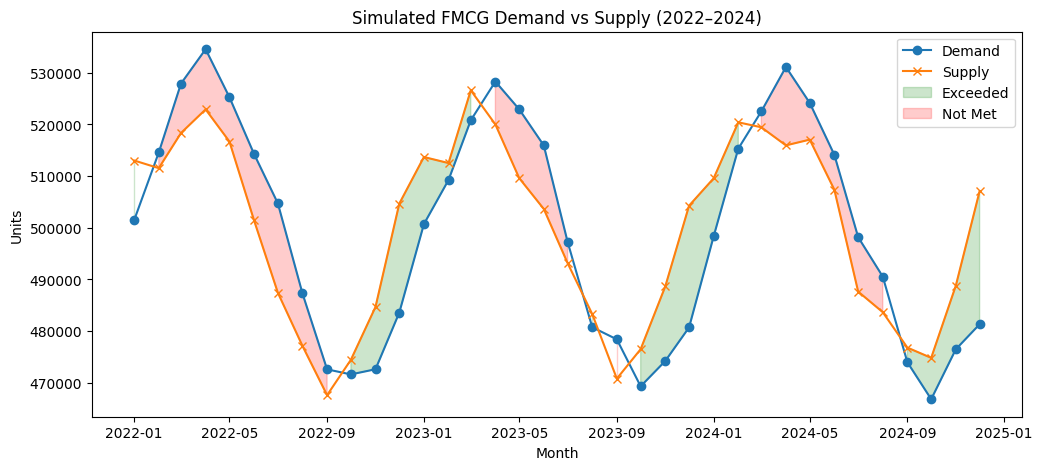

              Demand    Supply    Status
Month                                   
2022-01-01  501490.0  513030.0  Exceeded
2022-02-01  514585.0  511551.0   Not Met
2022-03-01  527924.0  518352.0   Not Met
2022-04-01  534569.0  522924.0   Not Met
2022-05-01  525278.0  516700.0   Not Met
2022-06-01  514298.0  501447.0   Not Met
2022-07-01  504738.0  487436.0   Not Met
2022-08-01  487302.0  477145.0   Not Met
2022-09-01  472611.0  467614.0   Not Met
2022-10-01  471628.0  474461.0  Exceeded


In [59]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

# Parameters
np.random.seed(42)
months = pd.date_range(start="2022-01-01", end="2024-12-31", freq='MS')

# Simulate data
demand = np.round(
    500000 
    + 30000*np.sin(np.arange(len(months))*2*np.pi/12)  # seasonal pattern
    + np.random.normal(0, 3000, len(months)), 0
)

# Supply slightly lags demand and has its own noise
supply = np.round(
    500000
    + 25000*np.sin((np.arange(len(months))*2*np.pi/12) + 0.5)  # phase shift
    + np.random.normal(0, 5000, len(months)), 0
)

# Create dataframe
data = pd.DataFrame({
    "Month": months,
    "Demand": demand,
    "Supply": supply
})

# Add status column
def status(d, s):
    if abs(d - s) <= 2000:  # within ±2k units → "Met"
        return "Met"
    elif s > d:
        return "Exceeded"
    else:
        return "Not Met"

data["Status"] = [status(d, s) for d, s in zip(data["Demand"], data["Supply"])]

data.set_index("Month", inplace=True)

# Plot
plt.figure(figsize=(12, 5))
plt.plot(data.index, data["Demand"], label="Demand", marker='o')
plt.plot(data.index, data["Supply"], label="Supply", marker='x')
plt.fill_between(data.index, data["Demand"], data["Supply"], 
                 where=(data["Supply"] > data["Demand"]), 
                 color='green', alpha=0.2, label="Exceeded")
plt.fill_between(data.index, data["Demand"], data["Supply"], 
                 where=(data["Supply"] < data["Demand"]), 
                 color='red', alpha=0.2, label="Not Met")
plt.title("Simulated FMCG Demand vs Supply (2022–2024)")
plt.xlabel("Month")
plt.ylabel("Units")
plt.legend()
plt.show()

print(data.head(10))
